In [1]:
from canny_edge_detector import CannyEdgeDetector
import numpy as np
import cv2
import os
from config import CURRENT_DIR
from scipy.ndimage.filters import convolve as convolveimg
from matplotlib import pyplot as plt

IMG_PATH = os.path.join(CURRENT_DIR, "norway_road.jpg")

road_img_bgr = cv2.imread(IMG_PATH)
road_img_rgb = cv2.cvtColor(road_img_bgr, cv2.COLOR_BGR2RGB)
road_img_gray = cv2.cvtColor(
    road_img_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32)

ced = CannyEdgeDetector(road_img_gray)
edge_img = ced.edge_detection(sigma=1, low_threshold_ratio=0.14,
                              high_threshold_ratio=0.3,)

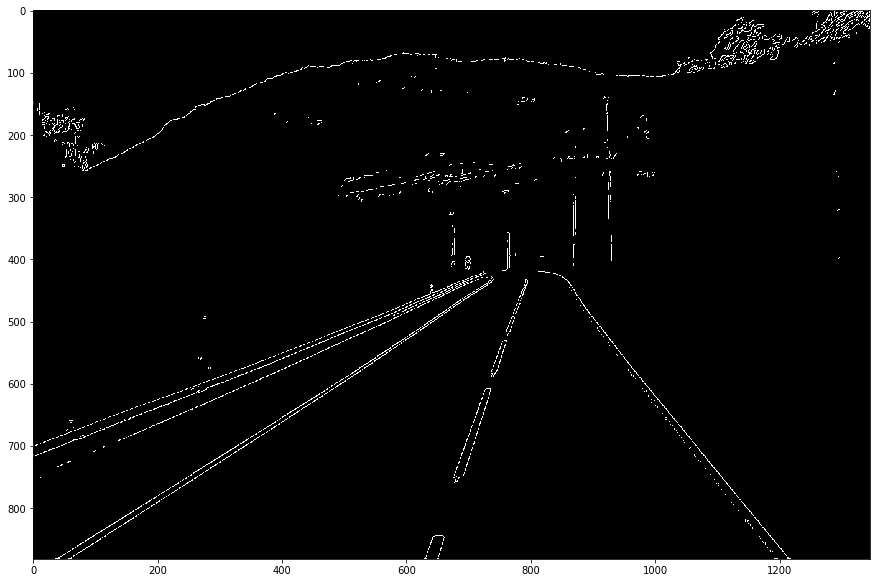

In [2]:
plt.figure(figsize=(15,15))
plt.imshow(edge_img, cmap="gray")

In [3]:
def estimate_hough_accumulator(edge_img):
    assert(edge_img.ndim==2)
    HEIGHT, WIDTH = edge_img.shape
    img_diagonal_length = int(np.hypot(HEIGHT, WIDTH))

    thetas = np.deg2rad(np.arange(-90, 91))
    ps = np.linspace(-img_diagonal_length, img_diagonal_length, 2 * img_diagonal_length + 1)
    
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)
    num_ps = len(ps)
    
    accumulator = np.zeros((num_ps, num_thetas), dtype=np.uint64)
    ys, xs = np.nonzero(edge_img)
    
    for y, x in zip(ys, xs):
        for i, (cos_val, sin_val) in enumerate(zip(cos_t, sin_t)):
            p_val = int(x * cos_val + y * sin_val ) + img_diagonal_length
            accumulator[p_val, i] += 1
 
    return accumulator, ps, thetas

In [4]:
def line_from_hough_transform(accumulator, ps, thetas, min_voting_num = 200, offset = 1000):
    ps_thetas_indices = np.where(accumulator > min_voting_num)
    lines = []
    
    for p_idx, theta_idx in zip(ps_thetas_indices[0], ps_thetas_indices[1]):
        p = ps[p_idx]
        theta = thetas[theta_idx]
              
        # Stores the value of cos(theta) in a 
        a = np.cos(theta) 
  
        # Stores the value of sin(theta) in b 
        b = np.sin(theta) 
      
        # x0 stores the value pcos(theta) 
        x0 = a*p
      
        # y0 stores the value psin(theta) 
        y0 = b*p
        
        # x1 stores the rounded off value of (pcos(theta)-offset * sin(theta)) 
        x1 = int(x0 + offset*(-b)) 
      
        # y1 stores the rounded off value of (psin(theta)+offset * cos(theta)) 
        y1 = int(y0 + offset*(a)) 
  
        # x2 stores the rounded off value of (pcos(theta)+offset * sin(theta)) 
        x2 = int(x0 - offset*(-b)) 
      
        # y2 stores the rounded off value of (psin(theta)-offset * cos(theta)) 
        y2 = int(y0 - offset*(a))
        
        lines.append(((x1, y1), (x2, y2)))
        
    return lines

accumulator, ps, thetas = estimate_hough_accumulator(edge_img)

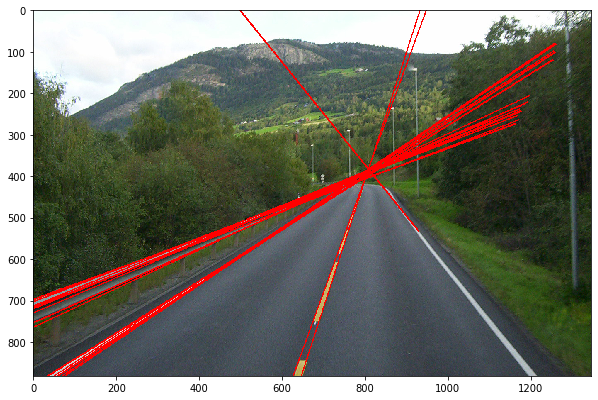

In [5]:
lines = line_from_hough_transform(accumulator, ps, thetas)

road_img_bgr_copied = np.copy(road_img_bgr)
for line in lines:
    (x1, y1), (x2, y2) = line
    cv2.line(road_img_bgr_copied,(x1,y1), (x2,y2), (0,0,255),2) 

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(road_img_bgr_copied, cv2.COLOR_BGR2RGB))

# using hough_line_detector

In [6]:
from hough_line_detector import HoughLineDetector
hld = HoughLineDetector(edge_img)
lines2 = hld.line_from_hough_transform(200, 2000)

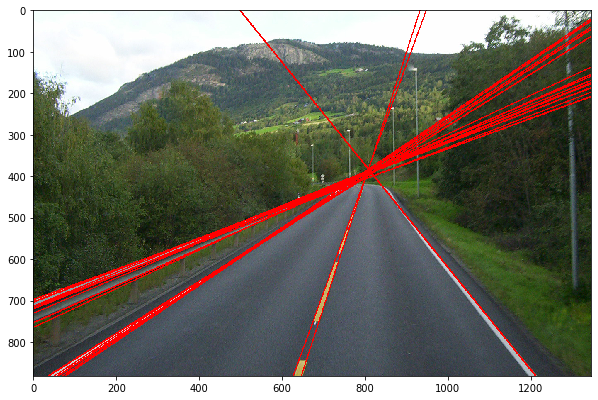

In [7]:
road_img_bgr_copied = np.copy(road_img_bgr)
for line in lines2:
    (x1, y1), (x2, y2) = line
    cv2.line(road_img_bgr_copied,(x1,y1), (x2,y2), (0,0,255),2) 
    
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(road_img_bgr_copied, cv2.COLOR_BGR2RGB))    

# using opencv function directly

In [26]:
line_image = np.zeros(road_img_bgr.shape, dtype=np.uint8)

In [27]:
rho = 1
theta = np.pi/180
threshold = 1
min_line_length = 10
max_line_gap = 1

lines = cv2.HoughLinesP(edge_img, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

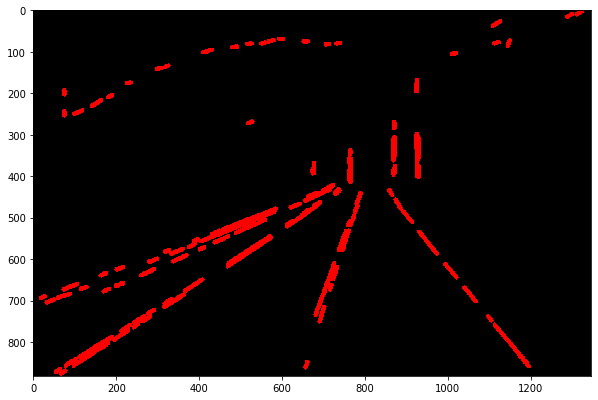

In [29]:
color_edges = np.dstack((edge_img, edge_img, edge_img)) 
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 

plt.figure(figsize=(10,10))
plt.imshow(line_image)

In [31]:
road_img_bgr.shape[:2]

(882, 1346)